In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/holiday-package-purchase-prediction/Travel.csv


In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import statsmodels.stats.proportion as sp

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('/kaggle/input/holiday-package-purchase-prediction/Travel.csv')
df.head()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,200000,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0


# Exploratory Data Analysis

### Descriptive Statistics

In [4]:
df.shape

(4888, 20)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CustomerID                4888 non-null   int64  
 1   ProdTaken                 4888 non-null   int64  
 2   Age                       4662 non-null   float64
 3   TypeofContact             4863 non-null   object 
 4   CityTier                  4888 non-null   int64  
 5   DurationOfPitch           4637 non-null   float64
 6   Occupation                4888 non-null   object 
 7   Gender                    4888 non-null   object 
 8   NumberOfPersonVisiting    4888 non-null   int64  
 9   NumberOfFollowups         4843 non-null   float64
 10  ProductPitched            4888 non-null   object 
 11  PreferredPropertyStar     4862 non-null   float64
 12  MaritalStatus             4888 non-null   object 
 13  NumberOfTrips             4748 non-null   float64
 14  Passport

In [6]:
cats = ['ProdTaken', 'CityTier', 'PreferredPropertyStar', 'Passport',
        'OwnCar', 'PitchSatisfactionScore', 'TypeofContact', 'Occupation', 'Gender', 'ProductPitched',
        'MaritalStatus', 'Designation']
nums = ['CustomerID', 'Age', 'DurationOfPitch',
       'NumberOfPersonVisiting', 'NumberOfFollowups',
       'NumberOfTrips',
       'NumberOfChildrenVisiting', 'MonthlyIncome']

In [7]:
df[cats] = df[cats].astype('object')

In [8]:
df.isnull().sum().sort_values(ascending=False)

DurationOfPitch             251
MonthlyIncome               233
Age                         226
NumberOfTrips               140
NumberOfChildrenVisiting     66
NumberOfFollowups            45
PreferredPropertyStar        26
TypeofContact                25
Designation                   0
OwnCar                        0
PitchSatisfactionScore        0
Passport                      0
CustomerID                    0
MaritalStatus                 0
ProdTaken                     0
NumberOfPersonVisiting        0
Gender                        0
Occupation                    0
CityTier                      0
ProductPitched                0
dtype: int64

In [9]:
df.duplicated().any()

False

In [10]:
dupes = df.drop('CustomerID', axis=1).duplicated()
print(f'Total Duplicate Rows: {dupes.sum()}')

Total Duplicate Rows: 141


In [11]:
df[nums].describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,4888.0,202443.500000,1411.188388,200000.0,201221.75,202443.5,203665.25,204887.0
Age,4662.0,37.622265,9.316387,18.0,31.00,36.0,44.00,61.0
DurationOfPitch,4637.0,15.490835,8.519643,5.0,9.00,13.0,20.00,127.0
NumberOfPersonVisiting,4888.0,2.905074,0.724891,1.0,2.00,3.0,3.00,5.0
NumberOfFollowups,4843.0,3.708445,1.002509,1.0,3.00,4.0,4.00,6.0
NumberOfTrips,4748.0,3.236521,1.849019,1.0,2.00,3.0,4.00,22.0
NumberOfChildrenVisiting,4822.0,1.187267,0.857861,0.0,1.00,1.0,2.00,3.0
MonthlyIncome,4655.0,23619.853491,5380.698361,1000.0,20346.00,22347.0,25571.00,98678.0


In [12]:
df[cats].describe().T

,count,unique,top,freq
ProdTaken,4888,2,0,3968
CityTier,4888,3,1,3190
PreferredPropertyStar,4862.0,3.0,3.0,2993.0
Passport,4888,2,0,3466
OwnCar,4888,2,1,3032
PitchSatisfactionScore,4888,5,3,1478
TypeofContact,4863,2,Self Enquiry,3444
Occupation,4888,4,Salaried,2368
Gender,4888,3,Male,2916
ProductPitched,4888,5,Basic,1842


In [13]:
for i in df[cats].columns:
    x = df[i].unique()
    print(f'{i}: {x}')
    print()

ProdTaken: [1 0]

CityTier: [3 1 2]

PreferredPropertyStar: [3.0 4.0 5.0 nan]

Passport: [1 0]

OwnCar: [1 0]

PitchSatisfactionScore: [2 3 5 4 1]

TypeofContact: ['Self Enquiry' 'Company Invited' nan]

Occupation: ['Salaried' 'Free Lancer' 'Small Business' 'Large Business']

Gender: ['Female' 'Male' 'Fe Male']

ProductPitched: ['Deluxe' 'Basic' 'Standard' 'Super Deluxe' 'King']

MaritalStatus: ['Single' 'Divorced' 'Married' 'Unmarried']

Designation: ['Manager' 'Executive' 'Senior Manager' 'AVP' 'VP']



In [14]:
df.replace('Fe Male','Female', inplace = True)

### Univariate Analysis

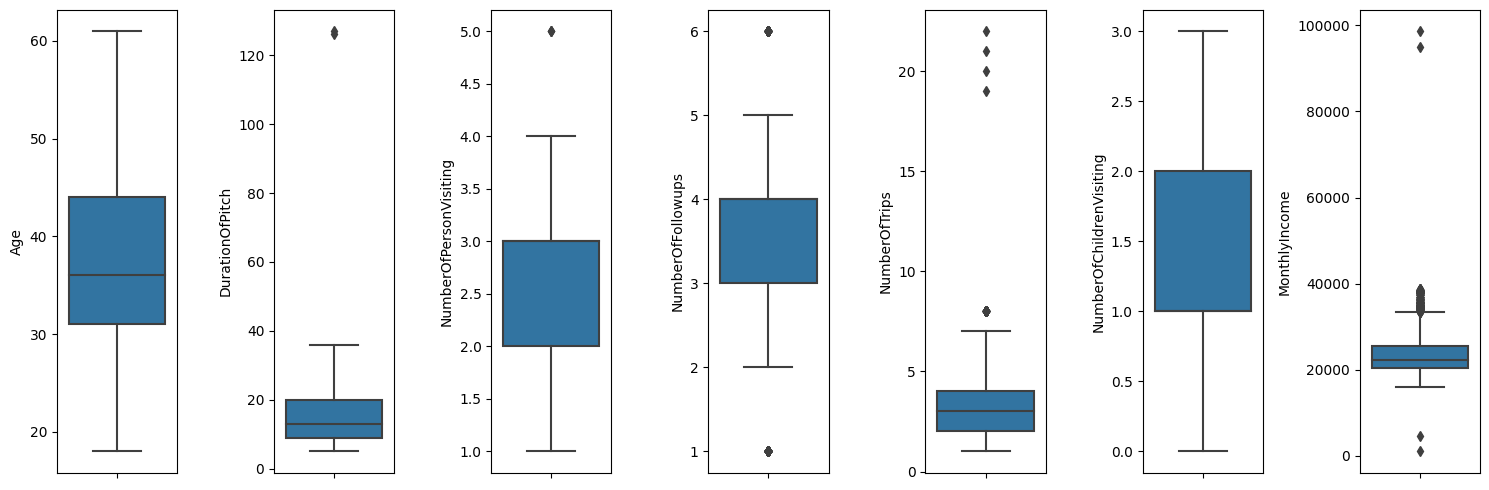

In [15]:
plt.figure(figsize=(15,5))
for i in range(1, len(nums)):
    plt.subplot(1, 7, i)
    sns.boxplot(y=df[nums[i]])
    plt.tight_layout()
plt.show()

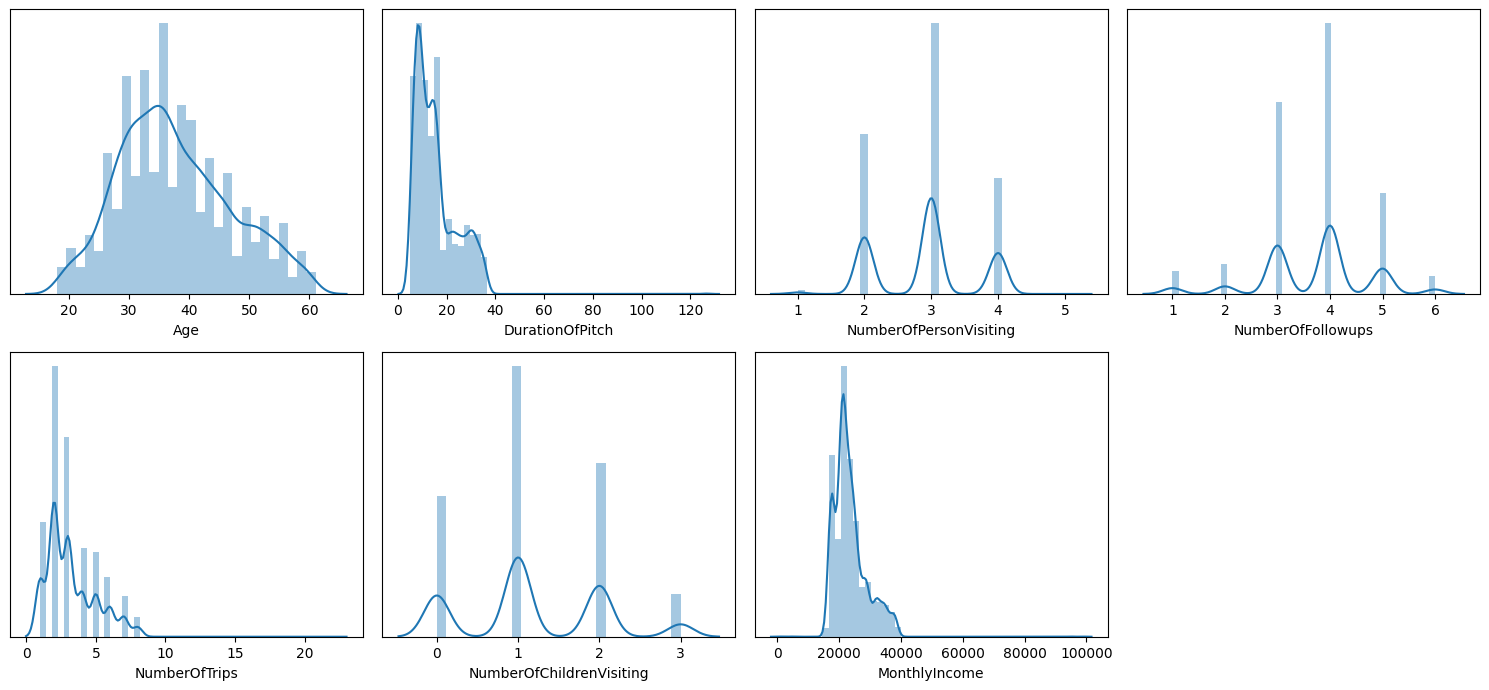

In [16]:
plt.figure(figsize=(15,10))
for i in range(1, len(nums)):
    plt.subplot(3, 4, i)
    sns.distplot(df[nums[i]])
    plt.ylabel('')
    plt.yticks([])
    plt.tight_layout()

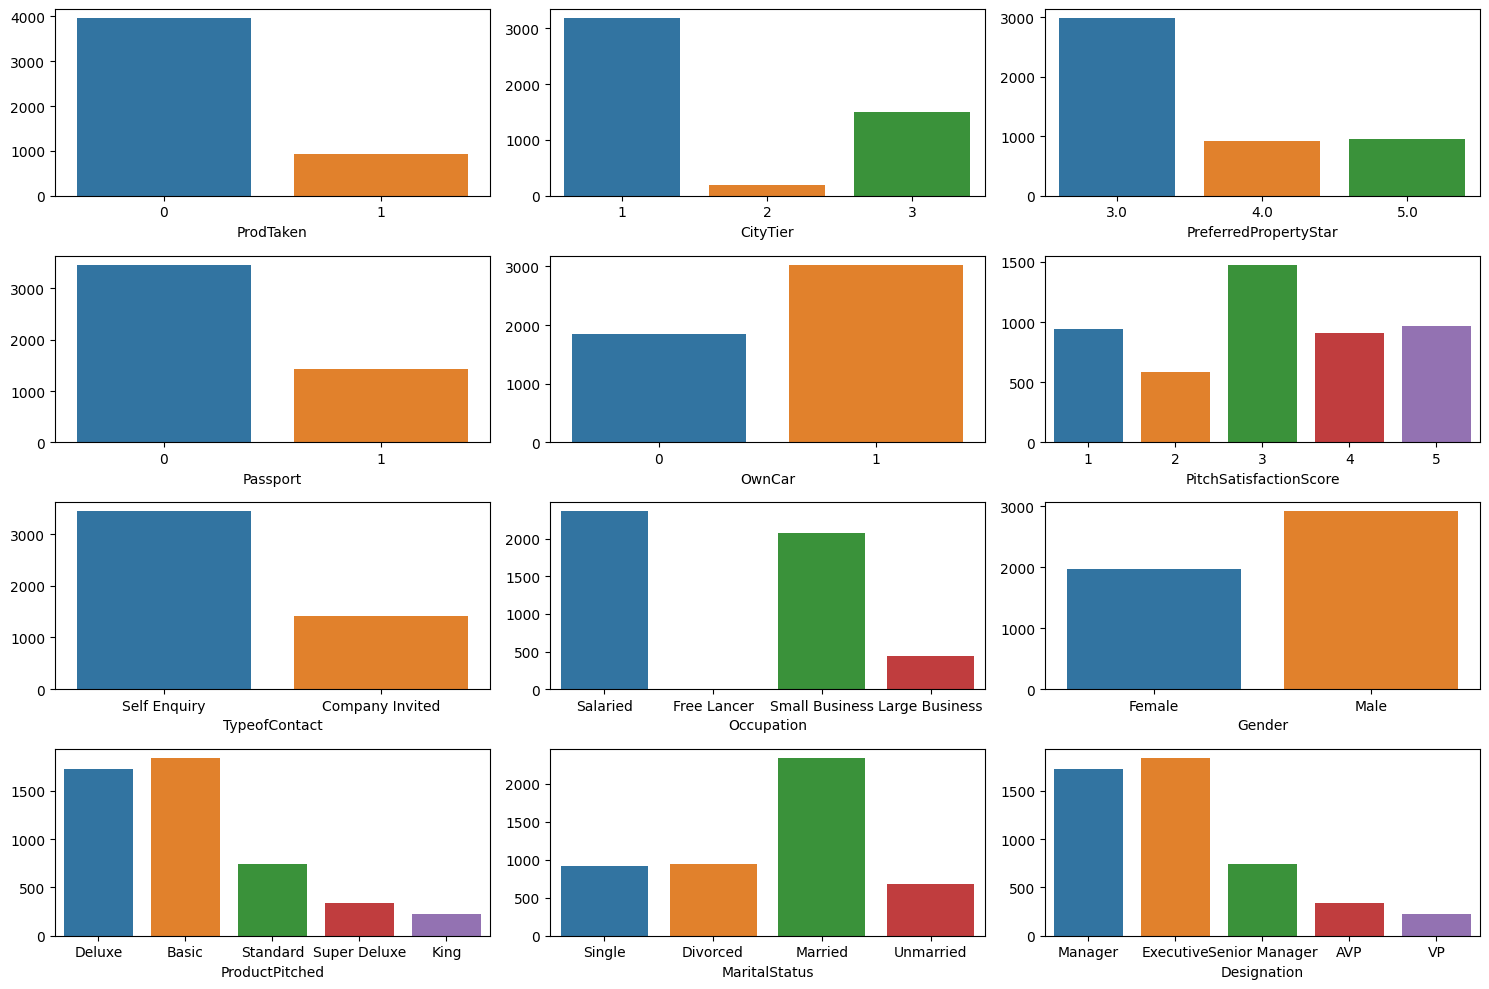

In [17]:
plt.figure(figsize=(15,10))
for i, col in enumerate(cats):
    plt.subplot(4, 3, i+1)
    sns.countplot(x=df[col])
    plt.ylabel('')
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.tight_layout()

### Multivariate Analysis

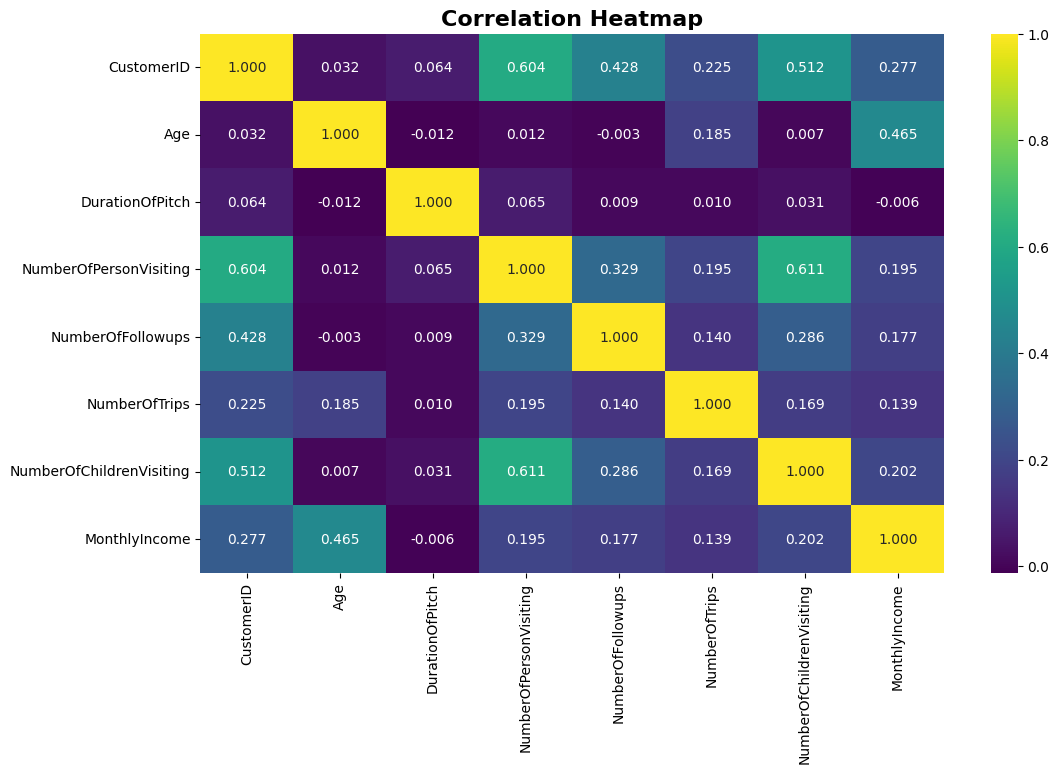

In [18]:
numeric_columns = df.select_dtypes(include='number')
plt.figure(figsize=(12,7))
plt.title('Correlation Heatmap', fontsize=16, fontweight='bold')
sns.heatmap(numeric_columns.corr(), cmap='viridis', annot=True, fmt='.3f')
plt.show()

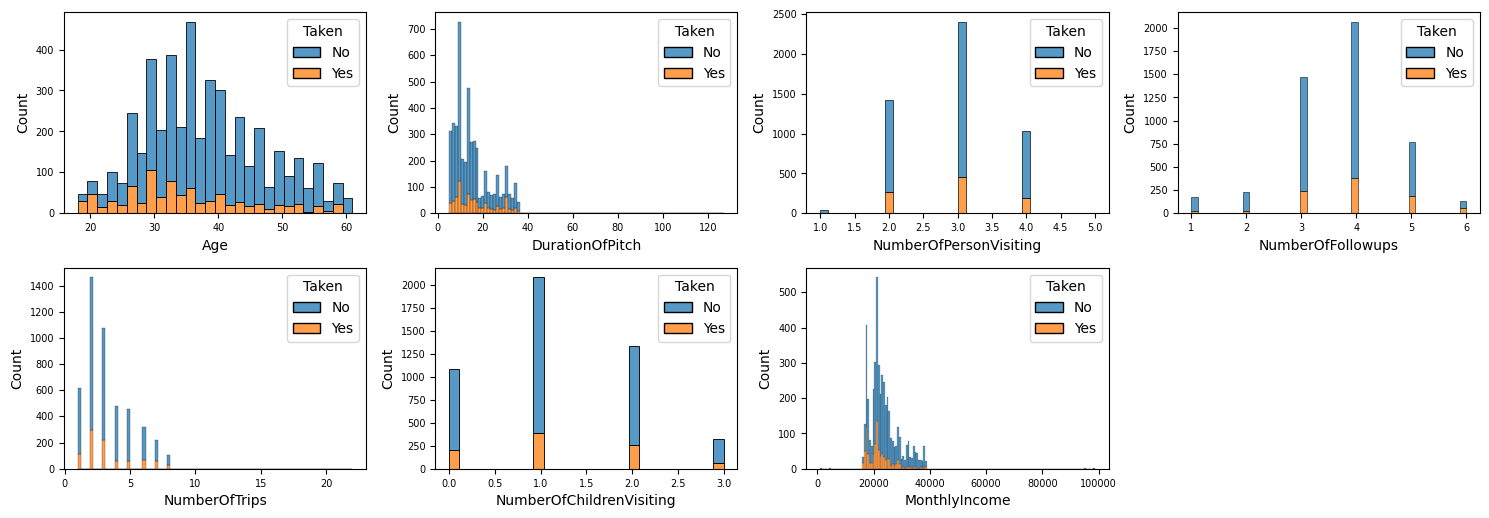

In [19]:
plt.figure(figsize=(15,10))
for i, col in enumerate(nums[1:]):
    plt.subplot(4, 4, i+1)
    plt.tick_params(axis='both', which='major', labelsize=7)
    sns.histplot(data=df, x=col, hue='ProdTaken', multiple='stack')
    
    legend = plt.gca().get_legend()
    legend.set_title('Taken')
    legend.get_texts()[0].set_text('No')
    legend.get_texts()[1].set_text('Yes')

plt.tight_layout()

plt.show()